4.4.4 多项式回归

In [59]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

In [60]:
max_degree  =50  # 多项式最大价数
n_train, n_test = 100, 100 # 训练集和测试集大小
true_w = np.zeros(max_degree)
true_w[:4] = np.array([5, 1.2 , -3.4, 5.6])

features = np.random.normal(size = (n_train + n_test, 1))

np.random.shuffle(features)
# 多项式
poly_features = np.power(features, np.arange(max_degree).reshape(1,-1))
# 除以阶乘
for i in range(max_degree):
    poly_features[:  , i] /= math.gamma(i+1)  # gama(i) 是 (i-1)!
# labels 的维度：(n_train + n_test, )
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale = 0.1 , size=labels.shape) 

In [61]:
# NumPy ndarry 转换为tensor
true_w , features, poly_features, labels = [torch.tensor(x, dtype = torch.float32) 
                                            for x in [true_w, features, poly_features, labels]]


In [62]:
features[ :2], poly_features[:2, :], labels[:2]

(tensor([[ 0.5792],
         [-0.2953]]),
 tensor([[ 1.0000e+00,  5.7916e-01,  1.6771e-01,  3.2377e-02,  4.6879e-03,
           5.4300e-04,  5.2414e-05,  4.3366e-06,  3.1394e-07,  2.0203e-08,
           1.1700e-09,  6.1604e-11,  2.9732e-12,  1.3246e-13,  5.4795e-15,
           2.1157e-16,  7.6582e-18,  2.6090e-19,  8.3945e-21,  2.5588e-22,
           7.4098e-24,  2.0435e-25,  5.3797e-27,  1.3546e-28,  3.2690e-30,
           7.5730e-32,  1.6869e-33,  3.6184e-35,  7.4845e-37,  1.4947e-38,
           2.8856e-40,  5.3908e-42,  9.8091e-44,  1.4013e-45,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 1.0000e+00, -2.9535e-01,  4.3616e-02, -4.2939e-03,  3.1705e-04,
          -1.8728e-05,  9.2190e-07, -3.8897e-08,  1.4360e-09, -4.7126e-11,
           1.3919e-12, -3.7371e-14,  9.1980e-16, -2.0897e

In [63]:
def evalute_loss(net, data_iter, loss):
    '''评估给定数据集上的损失'''
    metric = d2l.Accumulator(2) # 损失总和和样本数量
    for X , y  in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out , y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [64]:
def evaluate_accuracy(net, data_iter):
    '''计算在特定数据集上的正确率'''
    
    if  isinstance(net, torch.nn.Module):
        net.eval()
     # 累加器
    
    metric = d2l.Accumulator(2)
      
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(d2l.accuracy(net(X), y), y.numel())
    
    return metric[0] / metric[1]

In [65]:
def train_epoch_ch3(net, train_iter, loss, updater):
    '''训练一个迭代周期'''
    # 将模型设为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和， 训练准确度总和， 样本数
    metric = d2l.Accumulator(3)
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()),d2l.accuracy(y_hat, y), y.numel() )
    #返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

In [66]:
def train(train_features, test_features, train_lables, test_lables,
          num_epochs=400):
    loss = nn.MSELoss(reduce='none')
    
    input_shape = train_features.shape[-1]
    # 不设置偏置，多项式中已经实现， 前面的 5
    net = nn.Sequential(nn.Linear(input_shape , 1, bias=False))
    batch_size =min(10, train_lables.shape[0])
    train_iter = d2l.load_array((train_features,train_lables.reshape(-1,1)),batch_size)
    test_iter = d2l.load_array((test_features, test_lables.reshape(-1,1)), batch_size)

    trainer = torch.optim.SGD(net.parameters() , lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log', 
                            xlim=[1, num_epochs],ylim=[1e-3, 1e2],legend=['trian', 'test'])
    
    for epoch in range(num_epochs):
        train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch ==0 or (epoch+1) % 20 ==0:
            animator.add(epoch+1, (evalute_loss(net, train_iter, loss),
                                   evalute_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())





weight: [[ 4.996957   1.2195895 -3.3891623  5.5982857]]


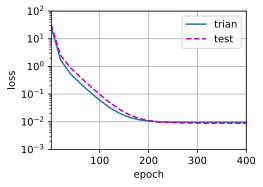

In [67]:
train(poly_features[    :n_train,    :4],poly_features[n_train:    , :4],
      labels[    :n_train], labels[n_train:   ] )

true_w = [5, 1.2 , -3.4, 5.6]
可见结果非常接近

weight: [[3.3703597 3.964126 ]]


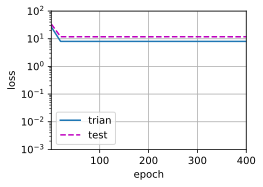

In [68]:
# 欠拟合， 只给部分数据
train(poly_features[:n_train, : 2], poly_features[n_train:, :2], 
      labels[:n_train], labels[n_train:])

weight: [[ 4.9747453   1.3002717  -3.2509472   5.137115   -0.428498    1.4835516
   0.03298692  0.16499221 -0.02825452 -0.03157926  0.04651177  0.1273191
  -0.10557599  0.04327119 -0.13103744  0.10716076  0.13090254 -0.11063196
  -0.09082909  0.05389018  0.10726254 -0.04011269 -0.0322171  -0.13230348
   0.13595991  0.03991831 -0.01786745  0.05077876  0.04099916  0.07029408
  -0.12776674 -0.1372589   0.02888384  0.09096716 -0.0493673   0.08493888
  -0.02169164  0.04870965 -0.1362004   0.12902759 -0.09826857  0.07581212
   0.12651737 -0.03422048  0.02208495 -0.0322434   0.03544693 -0.02109666
   0.03431802  0.09834264]]


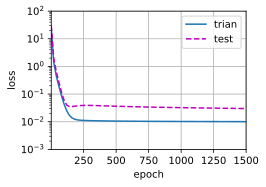

In [70]:
# 过拟合
train(poly_features[:n_train,:], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)